<a href="https://colab.research.google.com/github/aihoque2/fruit_object_detection/blob/master/object_detection_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip uninstall opencv-python-headless==4.5.5.62 
#!pip install opencv-python-headless==4.1.2.30

import torch
import numpy as np
import math
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
import torchvision.datasets.voc as VOC


import matplotlib.pyplot as plt
import matplotlib.patches as patches
# xml library for parsing xml files
from xml.etree import ElementTree as et
!pwd


/content


many of the libraries that i'm importing below can be found here:
https://github.com/pytorch/vision

in the repository, check `/references/detection/` for the files.

In [ ]:
#from google.colab import drive
#import os
#drive.mount('/content/drive')
#os.chdir('/content/drive/My Drive/Colab Notebooks/fruit_obj_detect')
#!pwd

In [ ]:
#image transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#standard libraries
from engine import train_one_epoch, evaluate
import utils
#import transforms as T


#our dataset file
#from dataset import FruitDataset

let's see if I have cuda on my desktop:

In [ ]:
torch.cuda.is_available()

True

graphics card specifications

In [ ]:
!nvidia-smi

Sun Mar 27 01:13:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8    13W / 310W |    971MiB /  7979MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_dir = 'data/train_zip/train/'
test_dir = 'data/test_zip/test/'

classes = ['_', 'apple', 'banana', 'orange']
!cd data && ls

test_zip  train_zip


# Viewing the dataset



Let's make our dataset class before creating our train and test datasets:

In [ ]:
import torch
import random
import cv2
import os

class FruitDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        #sort images for consistency
        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:] == '.jpg']
        self.classes = ['_', 'apple', 'banana', 'orange']

    def __getitem__(self, index):
        img_name = self.imgs[index]
        image_path = os.path.join(self.files_dir, img_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        
        #divide all pixels rgb vals by 255
        img_res /= 255.0

        #annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)

        root = tree.getroot()

        wt = img.shape[1]
        ht = img.shape[0]

        #box coordinates for xml files are extracted
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            #bounding box x coords
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            #bounding box y coords
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        #convert boxes into tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        #areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        #image_id
        image_id = torch.tensor([index])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs) 

Let's create our train dataset and view some files in it:

In [ ]:
train_data = FruitDataset(train_dir, 480, 480)
print("here's dataset length: ", len(train_data))

here's dataset length:  240


In [ ]:
my_img, my_target = train_data[24]
print("shape of the image: ", my_img.shape)
print("target: ", my_target)

shape of the image:  (480, 480, 3)
target:  {'boxes': tensor([[187.0769, 114.8064, 475.6923, 480.0000],
        [  1.8462,  43.7358, 292.3077, 480.0000]]), 'labels': tensor([1, 1]), 'area': tensor([105400.5078, 126717.9688]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([24])}


## Visualization

let's see how we can visualize some of our data:

In [ ]:
def plot_img_and_bbox(img, target):
    """
    bboxes are typically given to us
    in (x1, y1, x2, y2)
    plot the image with its bbox
    """
    
    classes = ['_', 'apple', 'banana', 'orange']
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for index, box in enumerate(target['boxes']):
        x, y = box[0], box[1]
        w = box[2] - box[0]
        h = box[3] - box[1]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, 
                                 edgecolor='b', facecolor='none')
        a.add_patch(rect)
        a.text(x, y-5, classes[int(target['labels'][index])], color="b") #adding the label on top of the bounding box
    plt.show()
        
    
    

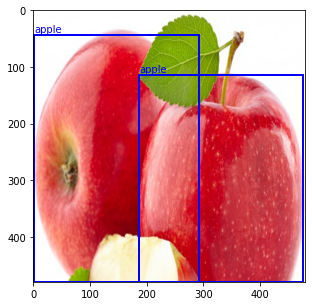

In [ ]:
plot_img_and_bbox(my_img, my_target)

# Model

let's load our Faster-RCNN below:

In [ ]:
def get_object_detector(num_classes):
    
    #load the pretrained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    #get number of input features for the classifier
    in_channels = model.roi_heads.box_predictor.cls_score.in_features
    
    #replace the ROI head with the new FastRCNN for predicting our classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels, num_classes)
    
    return model

and that's how you create a object detector for your custom dataset

# Data Augmentations

augmentating images in object detection is non-trivial because we need to make sure our bounding boxes align with the images correctly

here I do a random flip transform

In [ ]:
def get_transform(train):
    if train:
        #ToTensor is used to convert the images into a pytorch tensor
        return A.Compose([A.HorizontalFlip(0.5), ToTensorV2(p=1.0)],
                        bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                        bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

# Preparing the DataLoader

in order to load in data for training, we use a DataLoader object given by pytorch. This speeds up our training and allows us to use the GPU aswell.

In [ ]:
train_data = FruitDataset(train_dir, 480, 480, transforms=get_transform(train=True))
test_data = FruitDataset(test_dir, 480, 480, transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(train_data)).tolist() #get permutation of indices


#train test subset split set to 80/20
test_split = 0.2
train_split = 0.8

tsize = int(len(train_data)*test_split)
dataset = torch.utils.data.Subset(train_data, indices[:-tsize])
dataset_test = torch.utils.data.Subset(test_data, indices[-tsize:])

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)

In [ ]:
torch.cuda.is_available()
print("train_loader length: ", len(train_loader))
print("test_loader length: ", len(test_loader))

train_loader length:  20
test_loader length:  5


# Train

and now we train our model with our dataloade. first let's prepare our optimizer and put our model to train on cuda.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

num_classes = 4

model = get_object_detector(num_classes)
model.to(device) #load the model to our device for processing

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.05, momentum=0.9, weight_decay=0.0005)

#lr scheduler to decrease learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

time to train:

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    #evaluate(model, test_loader, device=device)

# Decode the predictions
use NMS (Non-Max-Suppresion) to filter out the bounding boxes. We use torchvision's NMS

In [ ]:
#function takes original predicition and the iou threshold
def apply_nms(orig_prediction, iou_thres=0.3):
    
    #get the indices of bboxes to keep
    keep_indices = torchvision.ops.nms(orig_prediction['boxes'],orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediciton['boxes'] = final_prediction['boxes'][keep_indices]
    final_prediction['scores'] = final_prediction['scores'][keep_indices]
    final_prediction['labels'] = final_prediction['labels'][keep_indices]
    
    return final_prediction

#convert torch tensor to pil image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our new model
now that we can decode these predictions, let's put this model to the test! We will compare how many bounding boxes are predicted vs actual bounding boxes present

In [ ]:
img, target = test_data[5]

model.eval() #puts model in evaluation mode

with torch.no_grad():
    prediction = model([img.to(device)])[0]
    print("PREDICTION OBJECT: ", type(prediction))

print("predicted boxes: ", len(prediction['labels']))
print('actual boxes: ', len(target['labels']))


PREDICTION OBJECT:  <class 'dict'>
predicted boxes:  100
actual boxes:  1


let's do some visualization of this prediction:

In [ ]:
#SAVE THE MODEL:
torch.save(model.state_dict(), "/content/fruit_faterRCNN.pth")

In [ ]:
print("EXPECTED OUTPUT")
numpy_img = img.numpy()
copy_img = numpy_img
print("numpy image shape: ", numpy_img.shape)
print("copy_img shape: ", copy_img.shape)
plot_img_and_bbox(copy_img, target)

here's what the model predicted:

In [ ]:
print("predicted output: ")
plot_img_and_bbox(img, prediction)

In [ ]:
#WITH NMS APPLIED
print("NMS prediction")
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
plot_img_and_bbox(img, nms_prediction)

In [ ]:
#test another image
img, target = dataset_test[10]